In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
# Make tensorflow not take over the entire GPU memory
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

import numpy as np
from matplotlib import pyplot as plt
from tfga import GeometricAlgebra

np.set_printoptions(precision=2, suppress=True)

### Introduction

Classical electromagnetism is most often described using maxwell's equations. Instead, we can also describe it using a Lagrange density and an action which is the spacetime integral over the Lagrange density.
The field is represented by a 4-vector in the [spacetime-algebra](https://en.wikipedia.org/wiki/Spacetime_algebra) where the first component is the electric potential and the last three components are the magnetic vector potential. Such as 4-vector is given at every point in spacetime. The Lagrangian density at a spacetime point $X = (t, x, y, z)$ for such a 4-vector field $A(X)$ without external sources is given by the following equation:

$\mathcal{L}(A, X) = \langle \nabla_X A(X) * \widetilde{\nabla_X A}(X) \rangle_0$

for speed of light $c = 1$. The [principle of stationary action](https://en.wikipedia.org/wiki/Principle_of_least_action) says that the classical solution of the field is achieved when the action

$S(A) = \int_{X}{\mathcal{L}(A, X) dX}$

does not change anymore, that is $\delta S(A) = 0$.

### Create the spacetime algebra with bases $e_0=e_t, e_1=e_x, e_2=e_y, e_3=e_z$ and corresponding metric $[-1, 1, 1, 1]$

In [2]:
ga = GeometricAlgebra([-1, 1, 1, 1])

### Calculate the action
Here we calculate the action $S$ given a field configuration $A(X)$ on a discretized spacetime lattice of size $[N, N, N, N]$. We use the following boundary conditions for $A(X)$:

$A_{t=-1} = 0, A_{t=N} = 0$

$A_{x=-1} = 10 e_0, A_{x=N} = -5 e_0$

$A_{y=-1} = -10 e_0, A_{y=N} = 0$

$A_{z=-1} = 0, A_{z=N} = 0$

In [3]:
def get_action(config_a_variable):
    # config_a_variable will be of shape [N, N, N, N, 4].
    # We need to create a multivector of kind vector (ie. e0, e1, e2, e3) from it.
    config_a = ga.from_tensor_with_kind(config_a_variable, "vector")

    # Finite differences in each direction. Use the boundary conditions for the padded values here.
    config_dt_a = tf.pad(config_a, [[0, 1], [0, 0], [0, 0], [0, 0], [0, 0]]) - tf.pad(config_a, [[1, 0], [0, 0], [0, 0], [0, 0], [0, 0]])
    config_dx_a = tf.pad(config_a, [[0, 0], [0, 1], [0, 0], [0, 0], [0, 0]], constant_values=10) - tf.pad(config_a, [[0, 0], [1, 0], [0, 0], [0, 0], [0, 0]], constant_values=-5)
    config_dy_a = tf.pad(config_a, [[0, 0], [0, 0], [0, 1], [0, 0], [0, 0]], constant_values=-10) - tf.pad(config_a, [[0, 0], [0, 0], [1, 0], [0, 0], [0, 0]])
    config_dz_a = tf.pad(config_a, [[0, 0], [0, 0], [0, 0], [0, 1], [0, 0]]) - tf.pad(config_a, [[0, 0], [0, 0], [0, 0], [1, 0], [0, 0]])

    # Sum all the derivatives according to the action / lagrangian and return a single scalar value
    return (
        tf.reduce_sum(ga.geom_prod(config_dt_a, ga.reversion(config_dt_a))[..., 0]) +
        tf.reduce_sum(ga.geom_prod(config_dx_a, ga.reversion(config_dx_a))[..., 0]) +
        tf.reduce_sum(ga.geom_prod(config_dy_a, ga.reversion(config_dy_a))[..., 0]) +
        tf.reduce_sum(ga.geom_prod(config_dz_a, ga.reversion(config_dz_a))[..., 0])
    )

### Initialize the 4-vector field variable randomly

In [4]:
grid_size = [16, 16, 16, 16]

config_a_variable = tf.Variable(tf.random.normal([*grid_size, 4], seed=0))

### Optimize the 4-vector field variable to make the action stationary
In order to make the action stationary we use a loss function that is minimal when the action is stationary (ie. the gradient of the action with respect to the field configuration is 0).
We use the mean-squared error to create such a loss function, although other functions such as the absolute value would work too.

We use Tensorflow's Adam optimizer to then change the field configuration in order to minimize the loss.

In [5]:
optimizer = tf.optimizers.Adam(0.01)

@tf.function
def train_step(config_a_variable):
    # Principle of stationary action:
    # Minimize the distance of gradient of the action to zero with respect to our field
    with tf.GradientTape() as tape_outer:
        tape_outer.watch(config_a_variable)
        with tf.GradientTape() as tape:
            tape.watch(config_a_variable)
            loss = get_action(config_a_variable)

        grads = tape.gradient(loss, [config_a_variable])
        grads_mse = tf.reduce_mean(tf.square(grads))
    grads2 = tape_outer.gradient(grads_mse, [config_a_variable])
    optimizer.apply_gradients(zip(grads2, [config_a_variable]))

for i in range(3000):
    train_step(config_a_variable)

### Extract and visualize the optimized electric field

In [6]:
config_a = ga.from_tensor_with_kind(config_a_variable, "vector")

# Extract the electric potential from the field configuration (ie. the e_0 component)
electric_potential = ga.select_blades(config_a, "0")

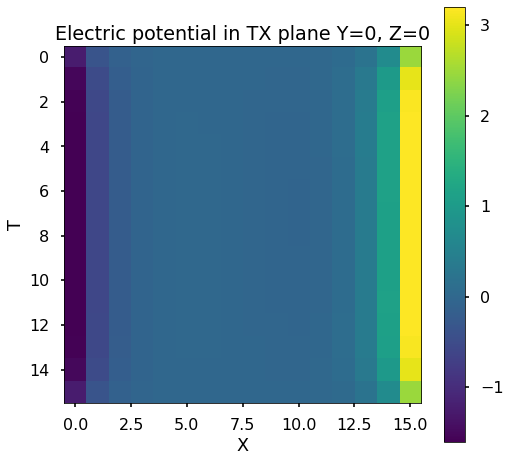

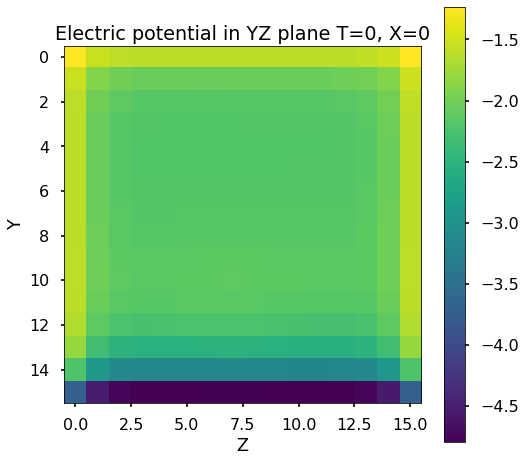

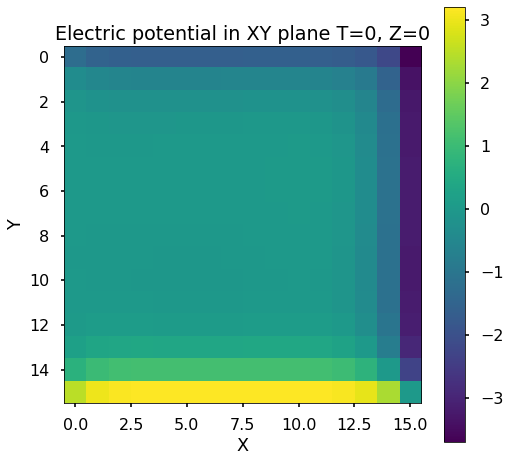

In [7]:
# Plot electric potential slices

with plt.style.context("seaborn-poster"):
    plt.figure(figsize=(8, 8))
    plt.imshow(config_a_variable[..., 0, 0, 0])
    plt.colorbar()
    plt.title("Electric potential in TX plane Y=0, Z=0")
    plt.xlabel("X")
    plt.ylabel("T")
    plt.show()

    plt.figure(figsize=(8, 8))
    plt.imshow(config_a_variable[..., 0, 0, :, :, 0])
    plt.colorbar()
    plt.title("Electric potential in YZ plane T=0, X=0")
    plt.xlabel("Z")
    plt.ylabel("Y")
    plt.show()

    plt.figure(figsize=(8, 8))
    plt.imshow(config_a_variable[..., 0, :, :, 0, 0])
    plt.colorbar()
    plt.title("Electric potential in XY plane T=0, Z=0")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

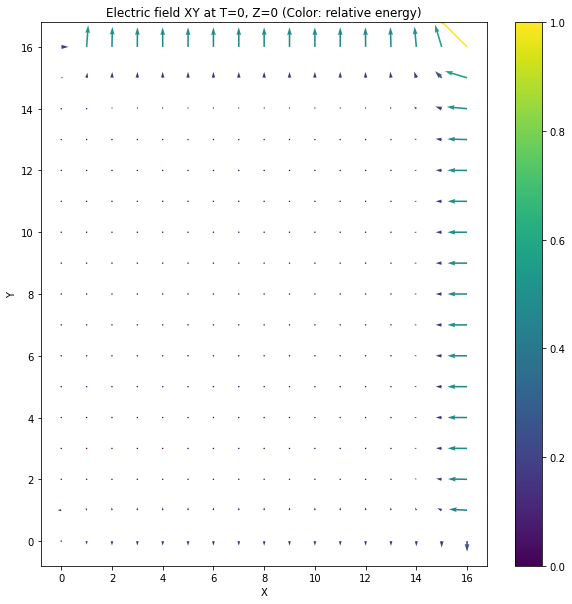

In [8]:
# Plot electric vector field XY slice at T=0, Z=0.
# Also use the energy for its color.

# Extract XY slice of electric potential [T=0, X, Y, Z=0, 0]
electric_potential = config_a_variable[..., 0, :, :, 0, 0]

# E = grad phi
electric_field_x = tf.pad(electric_potential, [[0, 1], [0, 0]], constant_values=10) - tf.pad(electric_potential, [[1, 0], [0, 0]])
electric_field_y = tf.pad(electric_potential, [[0, 0], [0, 1]], constant_values=-10) - tf.pad(electric_potential, [[0, 0], [1, 0]])

xs, ys = np.meshgrid(np.arange(16+1), np.arange(16+1))

ex = tf.pad(electric_field_x, [[0, 0], [1, 0]])
ey = tf.pad(electric_field_y, [[1, 0], [0, 0]])
energy = tf.sqrt(ex * ex + ey * ey)
max_energy = tf.reduce_max(energy)
plt.figure(figsize=(10, 10))
plt.quiver(xs, ys, ey, ex, energy/max_energy, scale=25, scale_units="inches")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Electric field XY at T=0, Z=0 (Color: relative energy)")
plt.colorbar()
plt.show()